15mins

In [1]:
import os
import time
import csv
import signal
import itertools
import random
import numpy as np
from tqdm import tqdm

from concurrent.futures import ProcessPoolExecutor, TimeoutError
from rasengan.problems.graph_coloring_problem import generate_gcp
from rasengan.solvers.optimizers import CobylaOptimizer
from rasengan.solvers.qiskit import (
    RasenganSegmentedSolver,
    DdsimProvider, NoisyDdsimProvider,
)
np.random.seed(0x7f)
random.seed(0x7f)

In [2]:
num_cases = 5

gcp_problems_pkg, gcp_configs_pkg = generate_gcp(num_cases, [(3, 1)])

In [3]:
algorithmic_evaluate_csv_path = 'algorithmic_evaluate.csv'

problems_pkg = list(
    itertools.chain(
        enumerate(gcp_problems_pkg),
    )
)

opt_modes = [[0, 0, 0, 0], [1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 1]]
evaluation_metrics = ['best_solution_probs', 'in_constraints_probs', 'ARG', 'iteration_count', 'classcial', 'quantum', 'run_times']
headers = ['pkid', 'pbid', 'layers', "variables", 'constraints', 'method'] + evaluation_metrics

def process_layer(prb, num_layers, opt_mode):
    opt = CobylaOptimizer(max_iter=200)
    ddsim = DdsimProvider(transpile_mode=0)

    prb.set_penalty_lambda(400)
    used_solver = RasenganSegmentedSolver(
        prb_model = prb,
        optimizer = opt,
        provider = ddsim,
        num_layers = num_layers,
        shots = 2048,
        opt_mode = opt_mode,
    )
    used_solver.solve()
    eval = used_solver.evaluation()
    time = list(used_solver.time_analyze())
    run_times = used_solver.run_counts()
    return eval + time + [run_times]


if __name__ == '__main__':
    all_start_time = time.perf_counter()
    set_timeout = 60 * 60 * 24 * 3 # Set timeout duration
    num_complete = 0
    # print(algorithmic_evaluate_csv_path)
    with open(f'{algorithmic_evaluate_csv_path}', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write headers once

    num_processes_cpu = os.cpu_count()
    # pkid-pbid: 问题包序-包内序号
    for pkid, (diff_level, problems) in enumerate(problems_pkg):
        for opt_mode in tqdm(opt_modes, desc="Algorithmic evaluation across opt_mode"):
            num_processes = num_processes_cpu // 4

            with ProcessPoolExecutor(max_workers=num_processes) as executor:
                futures = []
                layer = 5

                for pbid, prb in enumerate(problems):
                    # print(f'{pkid}-{pbid}, {layer}, {opt_mode} build')
                    future = executor.submit(process_layer, prb, layer, opt_mode)
                    futures.append((future, prb, pkid, pbid, layer, opt_mode))

                start_time = time.perf_counter()
                for future, prb, pkid, pbid, layer, opt_mode in tqdm(futures, desc="    processing", leave=False):
                    current_time = time.perf_counter()
                    remaining_time = max(set_timeout - (current_time - start_time), 0)
                    diff = []
                    try:
                        metrics = future.result(timeout=remaining_time)
                        diff.extend(metrics)
                        # print(f"Task for problem {pkid}-{pbid} L={layer} {opt_mode} executed successfully.")
                    except MemoryError:
                        print(f"Task for problem {pkid}-{pbid} L={layer} {opt_mode} encountered a MemoryError.")
                        for dict_term in evaluation_metrics:
                            diff.append('memory_error')
                    except TimeoutError:
                        print(f"Task for problem {pkid}-{pbid} L={layer} {opt_mode} timed out.")
                        for dict_term in evaluation_metrics:
                            diff.append('timeout')
                    except Exception as e:
                        print(f"An error occurred: {e}")
                    finally:
                        row = [pkid, pbid, layer, len(prb.variables), len(prb.lin_constr_mtx), opt_mode] + diff
                        with open(f'{algorithmic_evaluate_csv_path}', mode='a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow(row)  # Write row immediately
                        num_complete += 1
                        if num_complete == len(futures):
                            # print(f'problem_pkg_{pkid} has finished')
                            for process in executor._processes.values():
                                os.kill(process.pid, signal.SIGTERM)
    print(f'Data has been written to {algorithmic_evaluate_csv_path}')
    print(f"Time elapsed: {time.perf_counter() - all_start_time:.2f}s")

Algorithmic evaluation across opt_mode: 100%|██████████| 4/4 [00:57<00:00, 14.37s/it]

Data has been written to algorithmic_evaluate.csv
Time elapsed: 57.48s


In [4]:
noisy_evaluate_csv_path = 'noisy_evaluate.csv'

problems_pkg = list(
    itertools.chain(
        enumerate(gcp_problems_pkg),
    )
)

opt_modes = [[0, 0, 0, 0], [1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 1]]
evaluation_metrics = ['best_solution_probs', 'in_constraints_probs', 'ARG', 'iteration_count', 'classcial', 'quantum', 'run_times']
headers = ['pkid', 'pbid', 'layers', "variables", 'constraints', 'method'] + evaluation_metrics

def process_layer(prb, num_layers, opt_mode):
    opt = CobylaOptimizer(max_iter=200)
    ddsim = NoisyDdsimProvider(transpile_mode = 0)

    prb.set_penalty_lambda(400)
    used_solver = RasenganSegmentedSolver(
        prb_model = prb,
        optimizer = opt,
        provider = ddsim,
        num_layers = num_layers,
        shots = 1024,
        opt_mode = opt_mode,
    )
    used_solver.solve()
    eval = used_solver.evaluation()
    time = list(used_solver.time_analyze())
    run_times = used_solver.run_counts()
    return eval + time + [run_times]


if __name__ == '__main__':
    all_start_time = time.perf_counter()
    set_timeout = 60 * 60 * 24 * 3 # Set timeout duration
    num_complete = 0
    # print(noisy_evaluate_csv_path)
    with open(f'{noisy_evaluate_csv_path}', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write headers once

    num_processes_cpu = os.cpu_count()
    # pkid-pbid: 问题包序-包内序号
    for pkid, (diff_level, problems) in enumerate(problems_pkg):
        for opt_mode in tqdm(opt_modes, desc="Noisy evaluation across opt_mode"):
            num_processes = num_processes_cpu // 4

            with ProcessPoolExecutor(max_workers=num_processes) as executor:
                futures = []
                layer = 5

                for pbid, prb in enumerate(problems):
                    # print(f'{pkid}-{pbid}, {layer}, {opt_mode} build')
                    future = executor.submit(process_layer, prb, layer, opt_mode)
                    futures.append((future, prb, pkid, pbid, layer, opt_mode))

                start_time = time.perf_counter()
                for future, prb, pkid, pbid, layer, opt_mode in tqdm(futures, desc="    processing", leave=False):
                    current_time = time.perf_counter()
                    remaining_time = max(set_timeout - (current_time - start_time), 0)
                    diff = []
                    try:
                        metrics = future.result(timeout=remaining_time)
                        diff.extend(metrics)
                        # print(f"Task for problem {pkid}-{pbid} L={layer} {opt_mode} executed successfully.")
                    except MemoryError:
                        print(f"Task for problem {pkid}-{pbid} L={layer} {opt_mode} encountered a MemoryError.")
                        for dict_term in evaluation_metrics:
                            diff.append('memory_error')
                    except TimeoutError:
                        print(f"Task for problem {pkid}-{pbid} L={layer} {opt_mode} timed out.")
                        for dict_term in evaluation_metrics:
                            diff.append('timeout')
                    except Exception as e:
                        print(f"An error occurred: {e}")
                    finally:
                        row = [pkid, pbid, layer, len(prb.variables), len(prb.lin_constr_mtx), opt_mode] + diff
                        with open(f'{noisy_evaluate_csv_path}', mode='a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow(row)  # Write row immediately
                        num_complete += 1
                        if num_complete == len(futures):
                            # print(f'problem_pkg_{pkid} has finished')
                            for process in executor._processes.values():
                                os.kill(process.pid, signal.SIGTERM)
    print(f'Data has been written to {noisy_evaluate_csv_path}')
    print(f"Time elapsed: {time.perf_counter() - all_start_time:.2f}s")

Noisy evaluation across opt_mode: 100%|██████████| 4/4 [10:06<00:00, 151.65s/it]

Data has been written to noisy_evaluate.csv
Time elapsed: 606.61s


In [5]:
import pandas as pd

pd.set_option('display.max_rows', None)  # 显示所有行
pd.set_option('display.max_columns', None)  # 显示所有列

algorithmic_df = pd.read_csv(algorithmic_evaluate_csv_path)
algorithmic_grouped_df = algorithmic_df.groupby(['method'], as_index=False).mean()

noisy_df = pd.read_csv(noisy_evaluate_csv_path)
noisy_grouped_df = noisy_df.groupby(['method'], as_index=False).mean()

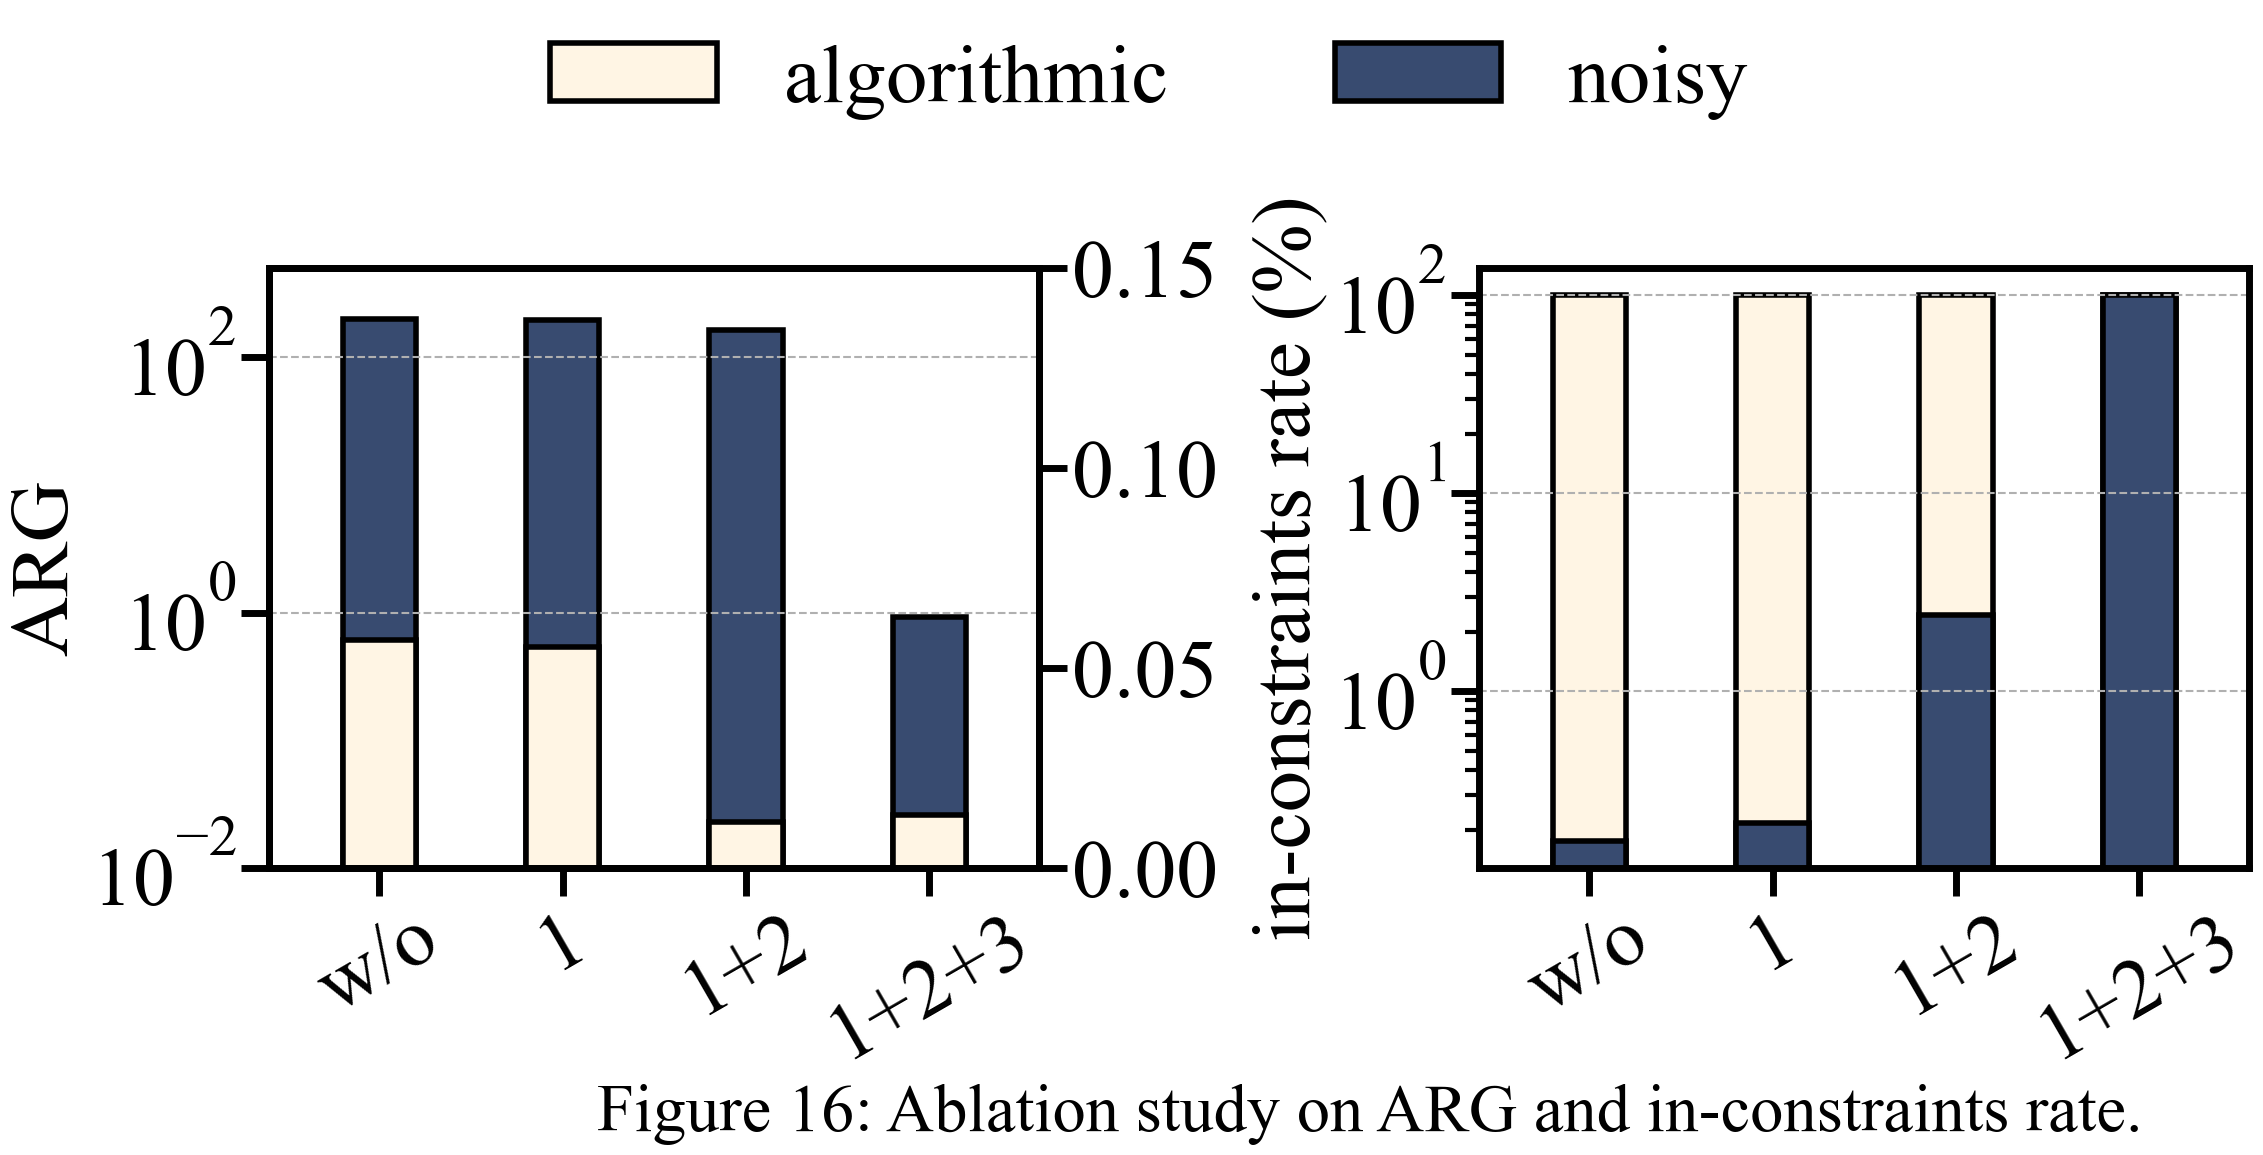

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# 图形风格设置
mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5,
    'xtick.major.size': 20,
    'xtick.major.width': 5,
    'xtick.minor.size': 10,
    'xtick.minor.width': 3,
    'ytick.major.size': 20,
    'ytick.major.width': 5,
    'ytick.minor.size': 10,
    'ytick.minor.width': 3,
    'lines.markersize': 35,
    'lines.markeredgewidth': 4,
    'markers.fillstyle': 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
})

# 设置方法和对应标签
methods = ['[0, 0, 0, 0]', '[1, 0, 0, 0]', '[1, 1, 0, 0]', '[1, 1, 1, 1]']
x_labels = ['w/o', '1', '1+2', '1+2+3']
x = np.arange(len(methods))
bar_width = 0.4

# 颜色
color_algo = '#FFF5E4'
color_classical = '#384B70'
edge_color = 'black'

# 错误棒参数
error_params = dict(elinewidth=3, ecolor='black', capsize=8, capthick=2)

# 图形创建
scale = 1
fig = plt.figure(figsize=(22 * scale, 12 * scale))
ax1 = plt.axes((0, 0, 0.35, 0.5))
ax1_1 = ax1.twinx()
ax2 = plt.axes((0.55, 0, 0.35, 0.5))

# 左图：ARG
for i, method in enumerate(methods):
    data_algo = algorithmic_grouped_df[algorithmic_grouped_df.method == method]
    data_noisy = noisy_grouped_df[noisy_grouped_df.method == method]

    ax1.bar(
        x[i],
        data_noisy['ARG'].values[0],
        width=bar_width,
        color=color_classical,
        edgecolor=edge_color,
        label='noisy' if i == 0 else "",
        error_kw=error_params,
        linewidth=4
    )
    
    ax1_1.bar(
        x[i],
        data_algo['ARG'].values[0],
        width=bar_width,
        color=color_algo,
        edgecolor=edge_color,
        label='algorithmic' if i == 0 else "",
        error_kw=error_params,
        linewidth=4
    )


ax1.set_ylabel('ARG')
ax1.set_yscale('log')
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels, rotation=30)
ax1.set_xlim(-0.6, len(x) - 0.4)
ax1.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax1.set_ylim(0.01, 500)
ax1_1.set_ylim(0, 0.15)

# 右图：In-Constraints Rate
for i, method in enumerate(methods):
    data_algo = algorithmic_grouped_df[algorithmic_grouped_df.method == method]
    data_noisy = noisy_grouped_df[noisy_grouped_df.method == method]

    ax2.bar(
        x[i],
        data_algo['in_constraints_probs'].values[0],
        width=bar_width,
        color=color_algo,
        edgecolor=edge_color,
        label='algorithmic' if i == 0 else "",
        error_kw=error_params,
        linewidth=4
    )

    ax2.bar(
        x[i],
        data_noisy['in_constraints_probs'].values[0],
        width=bar_width,
        color=color_classical,
        edgecolor=edge_color,
        label='noisy' if i == 0 else "",
        error_kw=error_params,
        linewidth=4
    )

ax2.set_ylabel('in-constraints rate (%)')
# ax2.set_ylim(0, 105)
ax2.set_xticks(x)
ax2.set_xticklabels(x_labels, rotation=30)
ax2.set_xlim(-0.6, len(x) - 0.4)
ax2.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax2.set_yscale('log')

# 图例：只画一次
handles, labels = ax2.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    ncol=2,
    frameon=False,
    bbox_to_anchor=(-0.1, 0.55, 1, 0.2),

)

title = "Figure 16: Ablation study on ARG and in-constraints rate"
plt.suptitle(title, y=-0.18, fontsize=48)
plt.savefig(f'{title}.svg', bbox_inches='tight')
plt.show()